# Monge Bregman Occam

## Aim of the notebook and theoretical background

This notebook is based on the results presented in: *Monge, Bregman and Occam: Interpretable Optimal Transport in High-Dimensions with Feature-Sparse Maps*, by Marco Cuturi, Michal Klein, Pierre Ablin.

The aim of the notebook is to explore the Monge Bregman estimator built on elastic costs $c(x,y) = h(x-y)$, where $h = \frac{1}{2}\lVert . \rVert^2_2+\tau$.

 Defined almost everywhere, the entropic map $T_{h,\epsilon}$ induces displacements $\Delta(x) = T(x) - x$ that align with Bregman centroids, derived from the Bregman divergence generated by $h$.

When $h$ incorporates an elastic-type regularizer, combining a squared-Euclidean norm $\ell_2^2$ with a regularizer $\tau$, these centroids are obtained using the proximal operator of $\tau$. Selecting a sparsifying norm for $\tau$ results in sparse displacement patterns $\Delta(x)$, which vary locally depending on $x$ and are influenced by the regularization strength of $\tau$.

After plotting examples in 2D, we will reproduce the synthetic experiment presented in the article and then try the Monge Bregman Occam estimator in the case of image color adaptation.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import pandas as pd
import numpy as np

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers.linear import sinkhorn

# Examples in 2D
 This first section is based on the OTT JAX tutorial on MBO Sparse Maps https://github.com/ott-jax/ott/blob/main/docs/tutorials/sparse_monge_displacements.ipynb

 ## First example of entropic map

 First, we calculate the "standard" entropic map between two distributions using the specified cost function, leveraging the `{class}` `ott.problems.linear.potentials.EntropicPotentials`. In accordance with the approach described by Pooladian et al. (2021), we solve this using the `{class}` `ott.solvers.linear.sinkhorn.Sinkhorn` method. Subsequently, OTT is employed to convert these solutions into a set of `{class}` `ott.problems.linear.potentials.DualPotentials` functions.

These dual potentials are then utilized to construct the entropic map, applying the `{meth}` `ott.problems.linear.potentials.DualPotentials.transport` method.

In [3]:
# Plotting utility


def plot_map(x, y, x_new=None, z=None, ax=None, title=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    ax.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    if z is not None:
        ax.quiver(
            *x_new.T,
            *(z - x_new).T,
            color="k",
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.007,
        )
        ax.scatter(
            *x_new.T, s=150, edgecolors="k", marker="o", label="$x_{new}$"
        )
        ax.scatter(
            *z.T,
            s=150,
            edgecolors="k",
            marker="X",
            label=r"$T_{x\rightarrow y}(x_{new})$",
        )
    if title is not None:
        ax.set_title(title)
    ax.legend(fontsize=22)

We generate our source samples `x` by sampling from a Gaussian distribution and our target samples `y` by drawing from a mixture of two Gaussians. We also draw some unseen samples `x_new` from the source distributions.


In [4]:
n_source = 30
n_target = 50
n_test = 10
p = 2

#source
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 4)
x = jax.random.normal(keys[0], (n_source, p))

#target
y0 = jax.random.normal(keys[1], (n_target // 2, p)) + jnp.array([5, 0])
y1 = jax.random.normal(keys[2], (n_target // 2, p)) + jnp.array([0, 8])
y = jnp.concatenate([y0, y1])

# new unseen sample
n_new = 10
x_new = jax.random.normal(keys[3], (n_new, p))

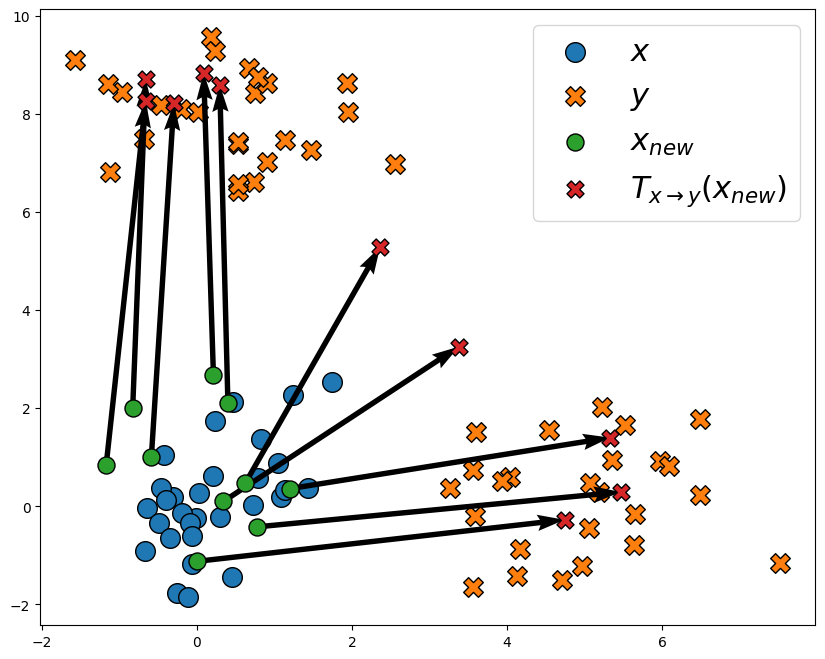

In [5]:
# jit first a Sinkhorn solver.
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport


map = entropic_map(x, y, costs.SqEuclidean())

plot_map(x, y, x_new, map(x_new))

In the case of a standard entropic map, the displacements don't have any particular structure.

##Example of Sparse Monge Displacements in 2D

We now turn to mixed costs, with the `{class}~ott.geometry.costs.ElasticL1` cost that corresponds to the function $h = \frac{1}{2}\lVert . \rVert^2_2+\texttt{scaling_reg}\lVert . \rVert_1$.



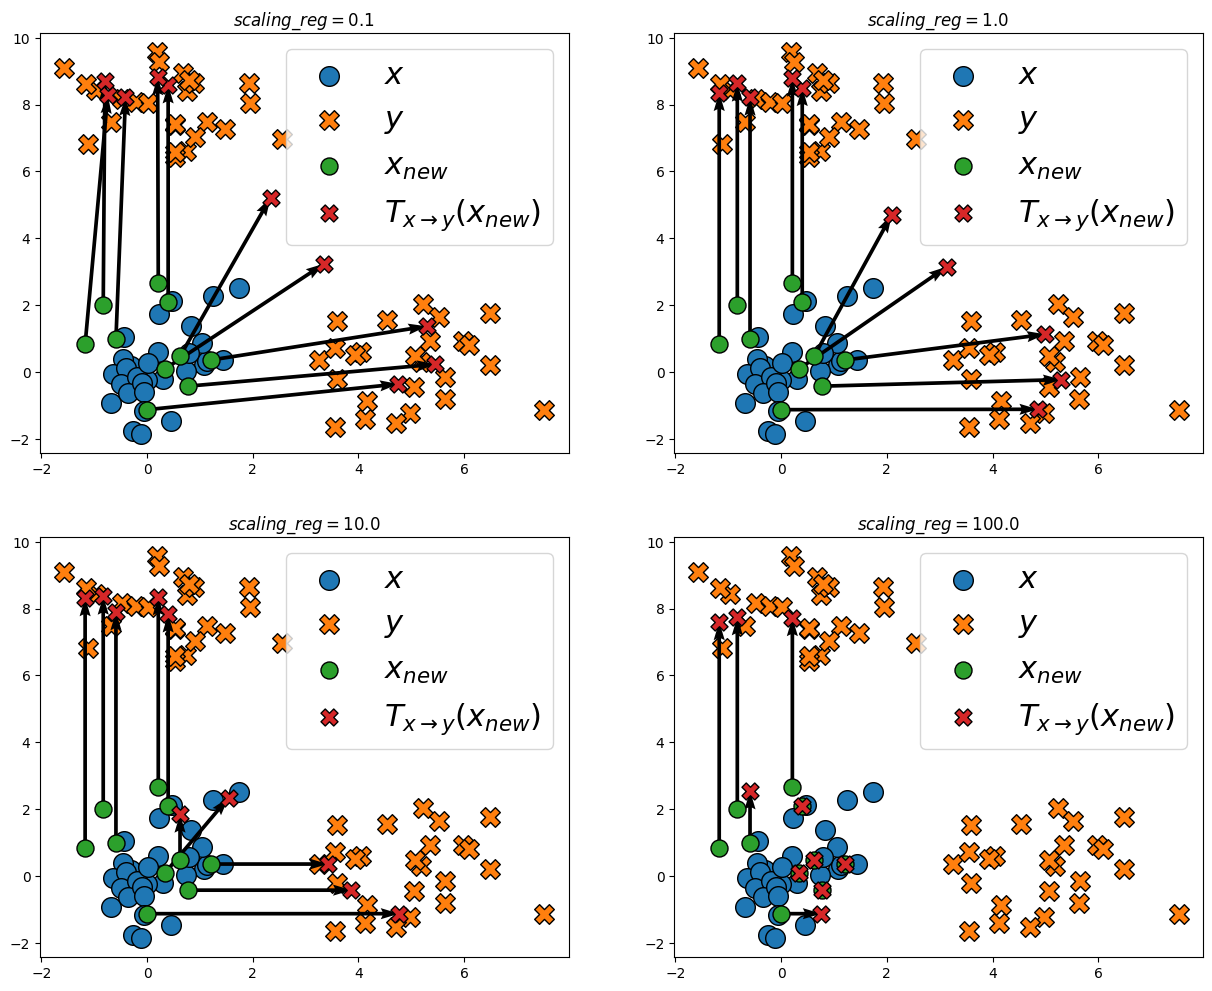

In [6]:
scaling_reg_list = [0.1, 1.0, 10.0, 100.0]

f, axe = plt.subplots(2, 2, figsize=(15, 12))
for scaling_reg, ax in zip(scaling_reg_list, axe.ravel()):
    map = entropic_map(x, y, costs.ElasticL1(scaling_reg=scaling_reg))
    plot_map(
        x,
        y,
        x_new,
        map(x_new),
        ax=ax,
        title=rf"$scaling\_reg = {scaling_reg}$",
    )

The observed data indicates that the displacement patterns across most samples exhibit sparsity when `scaling_reg` increases, with alterations typically confined to just one coordinate. Specifically, the altered coordinate varies by sample: certain samples exhibit movements solely along the x-axis, others solely along the y-axis, and a few along both axes.

It is apparent that a low `scaling_reg` value results in non-sparse displacements. As `scaling_reg` is increased, sparsity begins to manifest more prominently in the displacement patterns. Moreover, an excessively high `scaling_reg` value not only enhances sparsity but also causes significant shrinkage, as demonstrated in the final plot.

# Synthetic Experiment

## Constant sparsity-pattern

We reproduce the first synthetic experiment of the article.

Here, $\mu = \mathcal{U}[0,1]^d$. For an integer $s < d$, we set $\nu = T^\ast_s \sharp \mu$, where the map $T^\ast_s$ acts on coordinates independently with the formula
 $T^\ast_s(\mathbf{x}) = [\exp(x_1), \ldots, \exp(x_s), x_{s+1}, \ldots, x_d]$
it only changes the first $s$ coordinates of the vector, and corresponds to a sparse displacement when $s \ll d$.

We generate $n = 1,000$ i.i.d. samples $x_i$ from $\mu$, and $y_j$ from $\nu$ independently; the samples $y_j$ are obtained by first generating fresh i.i.d. samples $\tilde{x}_j$ from $\mu$ and then pushing them:
$y_j := T^\ast_s(\tilde{x}_j)$. We then use three sparsity inducing costs to compute $T_{h,ε}$ from these samples: $l_1$-regularized, Vanishing Shrinkage STVS (`{class}~ott.geometry.costs.ElasticSTVS`) and k-Overlap (`{class}~ott.geometry.costs.ElasticSqKOverlap`).

We measure our ability to recover $T^\ast_s$ from $T_{h,\epsilon}$ using a normalized MSE defined as
$\text{NMSE} = \frac{1}{n d} \sum_{i=1}^n \left\| T^\ast_s(x_i) - T_{h,\epsilon}(x_i) \right\|^2$.

We also measure how well our method identifies the correct support: for each sample, we compute the support error as
$\text{Support Error} = \frac{\sum_{i=s+1}^d \Delta_i^2}{\sum_{i=1}^d \Delta_i^2}$
where $\Delta$ represents the displacement $T_{h,\epsilon}(x) - x$. This quantity is between 0 and 1 and cancels if and only if the displacement happens only on the correct coordinates. We then average
this quantity overall the $x^{i}$.

In [7]:
def generate_source(n, dim, s, T, keys):
    x = jax.random.uniform(keys[0], (n, dim))
    x_tilde = jax.random.uniform(keys[1], (n, dim)) # x_tilde independent to x
    y = T(x_tilde,s)
    return x, y


def T_s(x,s) -> jnp.ndarray:
    return jnp.array([jnp.concatenate([jnp.exp(sub[:s]), sub[s:]]) for sub in x])


def nmse(x, s, map, T):
   return jnp.linalg.norm(T(x,s) - map(x)) ** 2 / (x.shape[0]*x.shape[1])


def support_error(x, s, map):
    delta_sq = (map(x) - x)**2
    sum_squares_part = jnp.sum(delta_sq[:, s:], axis=1)
    total_sum_squares = jnp.sum(delta_sq, axis=1)
    return jnp.mean(jnp.true_divide(sum_squares_part, total_sum_squares))


def experiment(n, d, s, scaling_reg_list, T, keys):
    NMSE_l1 = []
    NMSE_stvs = []
    NMSE_ovk_5 = []
    NMSE_ovk_7 = []
    NMSE_l2sq = []
    SE_l1 = []
    SE_stvs = []
    SE_ovk_5 = []
    SE_ovk_7 = []
    SE_l2sq = []
    for scaling_reg in scaling_reg_list:
        # Generating data to compute the entropic map
        x, y = generate_source(n, d, s, T, keys)
        # Compute $T_{h,ε}$
        map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg)) # l1 norm
        map_stvs = entropic_map(x, y, costs.ElasticSTVS(scaling_reg)) # SoftThresholding with Vanishing Shrinkage
        map_ovk_5 = entropic_map(x, y, costs.ElasticSqKOverlap(k=5 ,scaling_reg=scaling_reg)) # k-overlap norm with k=5
        map_ovk_7 = entropic_map(x, y, costs.ElasticSqKOverlap(k=7 ,scaling_reg=scaling_reg)) # k-overlap norm with k=7
        map_l2sq = entropic_map(x, y, costs.SqEuclidean()) # l_2^2 norm
        # Compute NMSE
        NMSE_l1 += [nmse(x, s, map_l1, T)]
        NMSE_stvs += [nmse(x, s, map_stvs, T)]
        NMSE_ovk_5 += [nmse(x, s, map_ovk_5, T)]
        NMSE_ovk_7 += [nmse(x, s, map_ovk_7, T)]
        NMSE_l2sq += [nmse(x, s, map_l2sq, T)]
        # Compute Support Error
        SE_l1 += [support_error(x, s, map_l1)]
        SE_stvs += [support_error(x, s, map_stvs)]
        SE_ovk_5 += [support_error(x, s, map_ovk_5)]
        SE_ovk_7 += [support_error(x, s, map_ovk_7)]
        SE_l2sq += [support_error(x, s, map_l2sq)]

    # Plot errors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    # NMSE plots
    ax1.plot(scaling_reg_list, NMSE_l1, label='l1', color='blue')
    ax1.plot(scaling_reg_list, NMSE_stvs, label='stvs', color='orange')
    ax1.plot(scaling_reg_list, NMSE_ovk_5, label='ovk, k=5', color='red')
    ax1.plot(scaling_reg_list, NMSE_ovk_7, label='ovk, k=7', color='purple')
    ax1.plot(scaling_reg_list, NMSE_l2sq, label='l2 squared', color='black', linestyle=':')
    ax1.set_xscale('log', base=10)
    ax1.set_yscale('log')
    ax1.set_xlabel('Regularization', fontsize=12, color='black')
    ax1.set_ylabel('NMSE', fontsize=12, color='black')
    ax1.set_title(f'd={d}, s={s}')
    ax1.legend()
    # Support error plots
    ax2.plot(scaling_reg_list, SE_l1, label='l1', color='blue')
    ax2.plot(scaling_reg_list, SE_stvs, label='stvs', color='orange')
    ax2.plot(scaling_reg_list, SE_ovk_5, label='ovk, k=5', color='red')
    ax2.plot(scaling_reg_list, SE_ovk_7, label='ovk, k=7', color='purple')
    ax2.plot(scaling_reg_list, SE_l2sq, label='l2 squared', color='black', linestyle=':')
    ax2.set_xscale('log',base=10)
    ax2.set_yscale('log')
    ax2.set_xlabel('Regularization', fontsize=12, color='black')
    ax2.set_ylabel('Support Error', fontsize=12, color='black')
    ax2.legend()

    plt.tight_layout()
    plt.show()




In [8]:
key = jax.random.PRNGKey(42)
keys = jax.random.split(key, 2)
n = 1000
s = 5
scaling_reg_list = jnp.logspace(start=-2, stop=1, num=20)

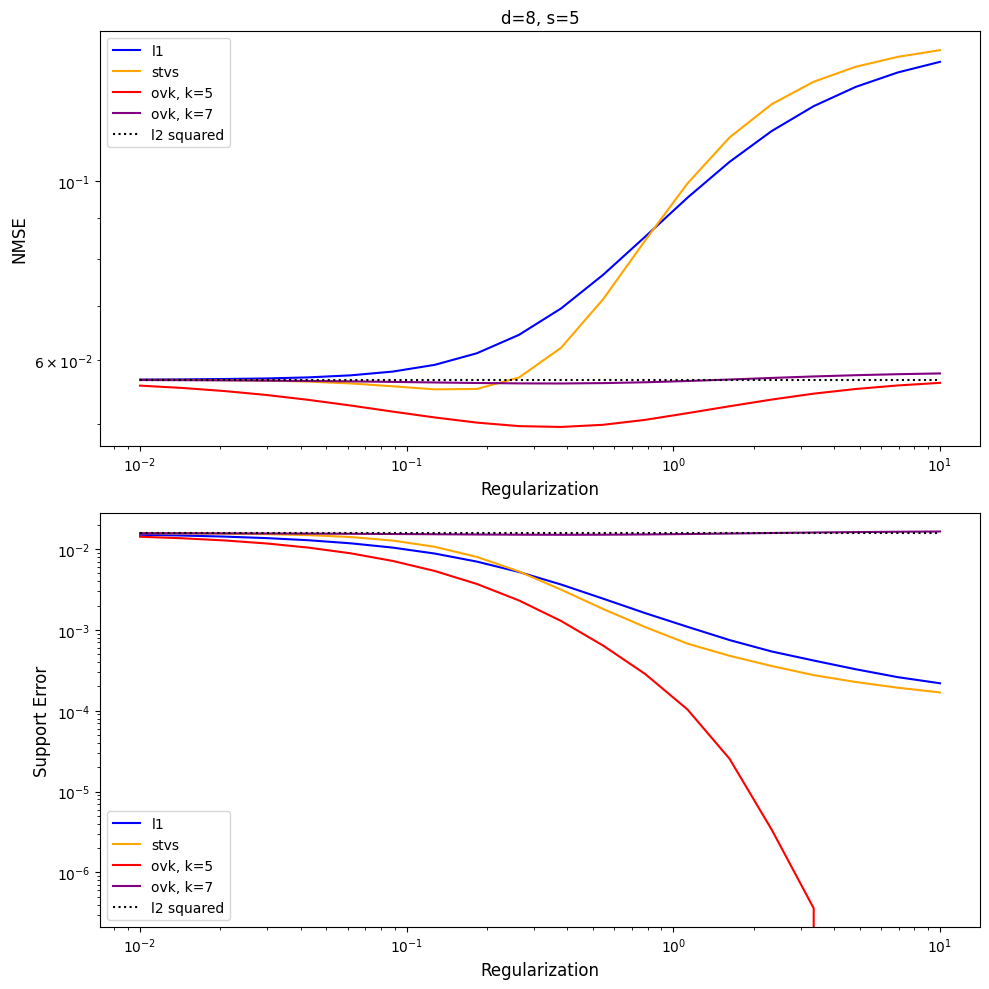

In [9]:
experiment(n, 8, s, scaling_reg_list, T_s, keys)

When s ≃ d, the $l^2_2$ cost is already good, and the
proposed costs barely improve over it in terms of NMSE

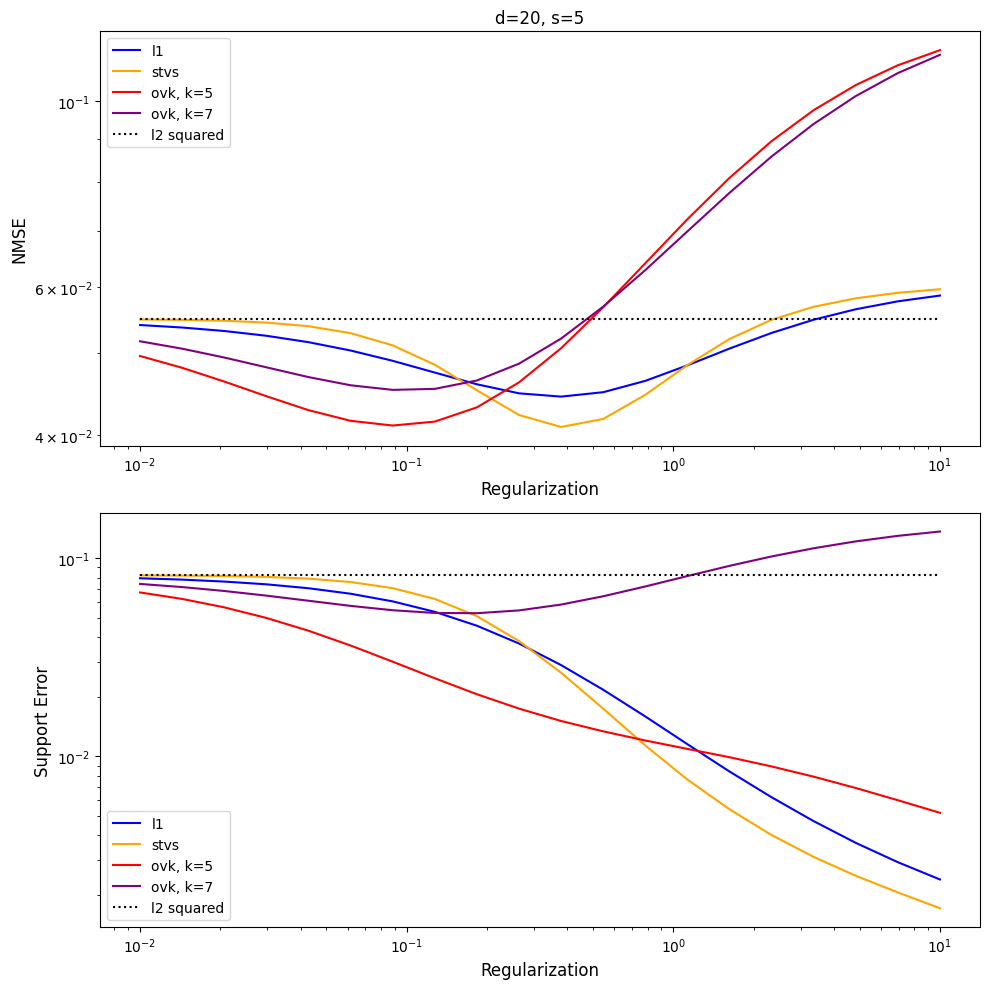

In [ ]:
experiment(n, 20, s, scaling_reg_list, T_s, keys)

When `d `is moderately larger than `s`, all the proposed costs improve
over the $l^2_2$ cost, and the optimal regularization for $l_1$ and $\tau_{stvs}$
are finite.

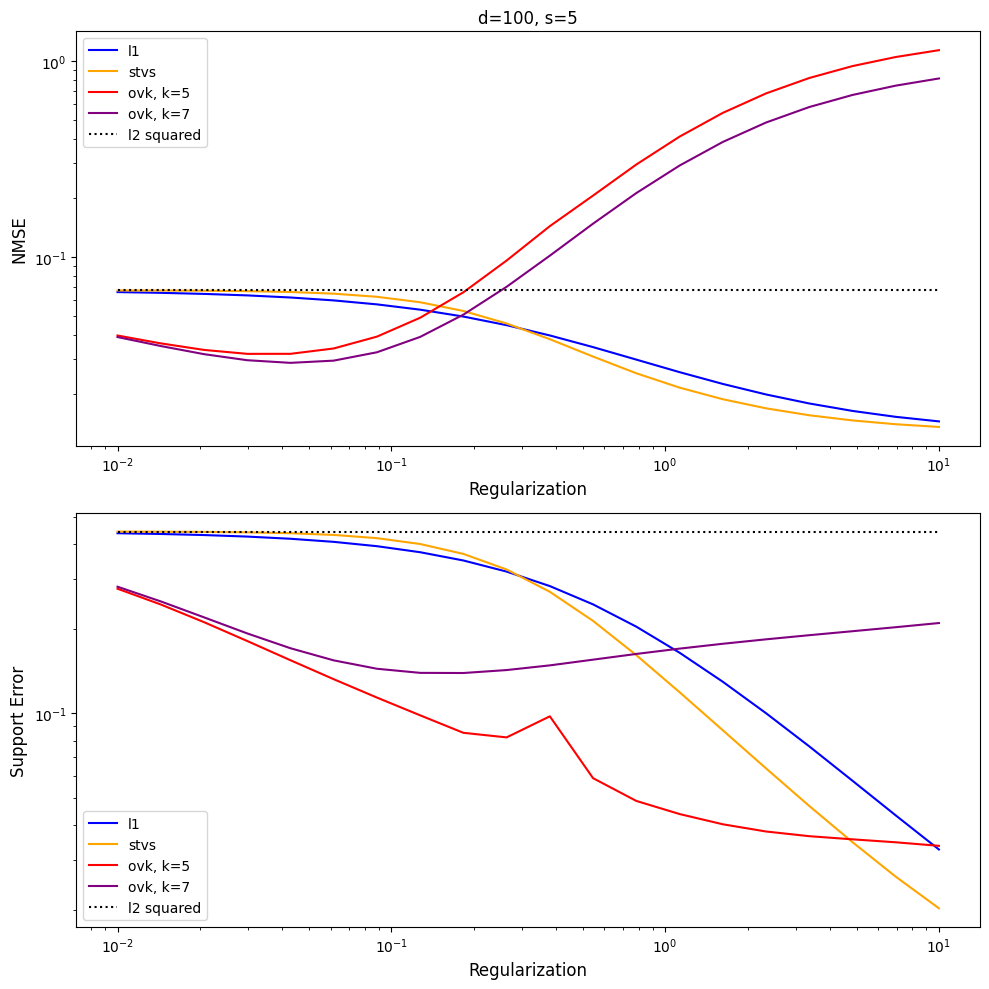

In [ ]:
experiment(n, 100, s, scaling_reg_list, T_s, keys)

When `d` ≫ `s`, the proposed methods vastly
improve over the $l_2^2$ cost. The optimal regularization for $l_1$ and
$\tau_{stvs}$ is infinite even for the MSE. In terms of support error, larger regularization leads to better results.

## $x$-dependent sparsity-pattern

The second experiment of the article consists in illustrating the ability of
the method to recover transport maps whose sparsity pattern
is adaptive, depending on the input $x$.

To compute $F_s(x)$, we first compute the norms of two coordinate groups of x:
$n_1 = \sum_{i=1}^{s} x_i^2 \quad \text{and} \quad n_2 = \sum_{i=s+1}^{2s} x_i^2.$
Second, we displace the coordinate group with the largest norm:

$F_s(x)$ = \begin{cases}
[ \exp(x_1), \ldots, \exp(x_s), x_{s+1}, \ldots, x_d ], & \text{if } n_1 > n_2, \\
[x_1, \ldots, x_s, \exp(x_{s+1}), \ldots, \exp(x_{2s}), x_{2s+1}, \ldots, x_d], & \text{otherwise}.
\end{cases}

For each d, we do a grid search over `scaling_reg` on a train fold, pick that with
the lowest NMSE, and report its test NMSE.


In [10]:
def F_s(x,s):
    output = []
    for sub in x:
        if jnp.linalg.norm(sub[:s]) > jnp.linalg.norm(sub[s:2*s+1]):
           output += [jnp.concatenate([jnp.exp(sub[:s]), sub[s:]])]
        else:
           output += [jnp.concatenate([sub[:s], jnp.exp(sub[s:2*s+1]), sub[2*s+1:]])]
    return jnp.array(output)


def gridsearch_reg(x, y, n, d, s, scaling_reg_list, T, keys):
    NMSE_l1 = []
    NMSE_stvs = []
    NMSE_ovk_5 = []
    NMSE_ovk_7 = []
    # Gridsearch on scaling_reg values
    for scaling_reg in scaling_reg_list:
        # Compute $T_{h,ε}$
        map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg)) # l1 norm
        map_stvs = entropic_map(x, y, costs.ElasticSTVS(scaling_reg)) # SoftThresholding with Vanishing Shrinkage
        map_ovk_5 = entropic_map(x, y, costs.ElasticSqKOverlap(k=5 ,scaling_reg=scaling_reg)) # k-overlap norm with k=5
        map_ovk_7 = entropic_map(x, y, costs.ElasticSqKOverlap(k=7 ,scaling_reg=scaling_reg)) # k-overlap norm with k=7
        # Compute NMSE
        NMSE_l1 += [nmse(x, s, map_l1, T)]
        NMSE_stvs += [nmse(x, s, map_stvs, T)]
        NMSE_ovk_5 += [nmse(x, s, map_ovk_5, T)]
        NMSE_ovk_7 += [nmse(x, s, map_ovk_7, T)]

    # optimal scaling_reg values for each norm
    scaling_reg_l1 = scaling_reg_list[NMSE_l1.index(min(NMSE_l1))]
    scaling_reg_stvs = scaling_reg_list[NMSE_stvs.index(min(NMSE_stvs))]
    scaling_reg_ovk_5 = scaling_reg_list[NMSE_ovk_5.index(min(NMSE_ovk_5))]
    scaling_reg_ovk_7 = scaling_reg_list[NMSE_ovk_7.index(min(NMSE_ovk_7))]

    return scaling_reg_l1, scaling_reg_stvs, scaling_reg_ovk_5, scaling_reg_ovk_7

def experiment_x_sparsity(n, n_new, d_list, s, scaling_reg_list, T, keys):
    NMSE_l1 = []
    NMSE_stvs = []
    NMSE_ovk_5 = []
    NMSE_ovk_7 = []
    NMSE_l2sq = []
    for d in d_list :
        # Generating data to compute the entropic map
        x, y = generate_source(n, d, s, T, keys)
        scaling_reg_l1, scaling_reg_stvs, scaling_reg_ovk_5, scaling_reg_ovk_7 = gridsearch_reg(x, y, n, d, s, scaling_reg_list, T, keys)
        # Compute $T_{h,ε}$
        map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg_l1)) # l1 norm
        map_stvs = entropic_map(x, y, costs.ElasticSTVS(scaling_reg_stvs)) # SoftThresholding with Vanishing Shrinkage
        map_ovk_5 = entropic_map(x, y, costs.ElasticSqKOverlap(k=5 ,scaling_reg=scaling_reg_ovk_5)) # k-overlap norm with k=5
        map_ovk_7 = entropic_map(x, y, costs.ElasticSqKOverlap(k=7 ,scaling_reg=scaling_reg_ovk_7)) # k-overlap norm with k=7
        map_l2sq = entropic_map(x, y, costs.SqEuclidean()) # l_2^2 norm
        # Generate new sample
        x_new = jax.random.uniform(keys[2], (n_new, d))
        # Compute NMSE
        NMSE_l1 += [nmse(x_new, s, map_l1, T)]
        NMSE_stvs += [nmse(x_new, s, map_stvs, T)]
        NMSE_ovk_5 += [nmse(x_new, s, map_ovk_5, T)]
        NMSE_ovk_7 += [nmse(x_new, s, map_ovk_7, T)]
        NMSE_l2sq += [nmse(x_new, s, map_l2sq, T)]

    # NMSE plots
    plt.plot(d_list, NMSE_l1, label='l1', color='blue')
    plt.plot(d_list, NMSE_stvs, label='stvs', color='orange')
    plt.plot(d_list, NMSE_ovk_5, label='ovk, k=5', color='red')
    plt.plot(d_list, NMSE_ovk_7, label='ovk, k=7', color='purple')
    plt.plot(d_list, NMSE_l2sq, label='l2 squared', color='black', linestyle=':')
    plt.xscale('log', base=10)
    plt.yscale('log')
    plt.xlabel('Dimension d', fontsize=12, color='black')
    plt.ylabel('NMSE', fontsize=12, color='black')
    plt.legend()
    plt.show()



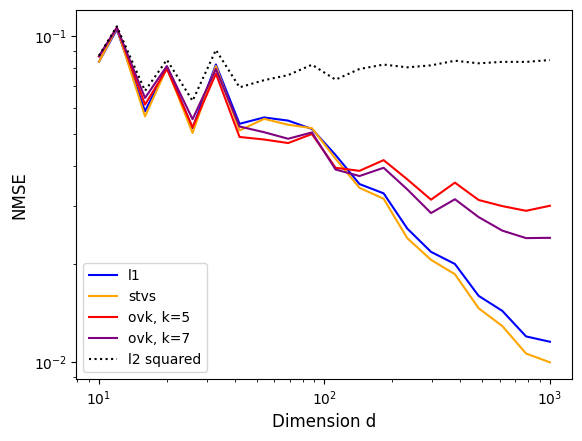

In [11]:
key = jax.random.PRNGKey(42)
keys = jax.random.split(key, 3)
d_list = jnp.floor(jnp.logspace(start=1, stop=3, num=20)).astype(int)
scaling_reg_list = jnp.logspace(start=-2, stop=1, num=20)

experiment_x_sparsity(100, 25, d_list, 2, scaling_reg_list, F_s, keys)

 We observe a much better scaling for our costs than for the standard $l_2^2$
cost, indicating that sparsity-inducing costs mitigate the
curse of dimensionality.

# Experiment on real data

We now want to try to apply this approach to transferring colors between two images and see how it behaves in respect to the value of `scaling_reg`.

## Import data from the CIFAR-10 Dataset

In [ ]:
# Load the CIFAR-10 dataset
(x, y), _ = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values of the images to be between 0 and 1
x = x / 255.0

# Filter out only the automobile images
car_indices = np.where(y == 1)[0]
car_images = x[car_indices]
car_labels = y[car_indices]

# Extract two car images
np.random.seed(25)
random_indices = np.random.choice(car_images.shape[0], 2, replace=False)
random_car_images = car_images[random_indices]
random_car_labels = car_labels[random_indices]


170498071/170498071 [==============================] - 11s 0us/step


## Create our training samples

In [ ]:
r = np.random.RandomState(42)


def im2mat(I):
    #Image to matrix (one pixel per line)
    return I.reshape((I.shape[0] * I.shape[1], I.shape[2]))


def mat2im(X, shape):
    #Matrix to image
    return X.reshape(shape)


def minmax(I):
    return np.clip(I, 0, 1)

In [ ]:
# Loading images
I1 = random_car_images[0]
I2 = random_car_images[1]

X1 = im2mat(I1)
X2 = im2mat(I2)

# training samples
nb = 300
idx1 = r.randint(X1.shape[0], size=(nb,))
idx2 = r.randint(X2.shape[0], size=(nb,))

X1_train = X1[idx1, :]
X2_train = X2[idx2, :]


## Plot images

Text(0.5, 1.0, 'Image 2')

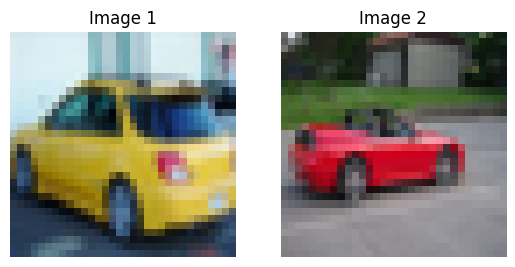

In [ ]:
pl.figure(1, figsize=(6.4, 3))

pl.subplot(1, 2, 1)
pl.imshow(I1)
pl.axis('off')
pl.title('Image 1')

pl.subplot(1, 2, 2)
pl.imshow(I2)
pl.axis('off')
pl.title('Image 2')

## Scatter plot of colors

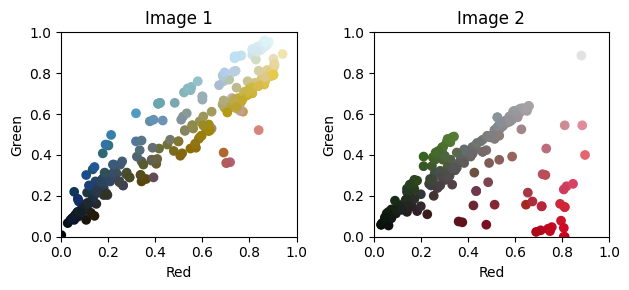

In [ ]:
pl.figure(2, figsize=(6.4, 3))

pl.subplot(1, 2, 1)
pl.scatter(X1_train[:, 0], X1_train[:, 1], c=X1_train)
pl.axis([0, 1, 0, 1])
pl.xlabel('Red')
pl.ylabel('Green')
pl.title('Image 1')

pl.subplot(1, 2, 2)
pl.scatter(X2_train[:, 0], X2_train[:, 1], c=X2_train)
pl.axis([0, 1, 0, 1])
pl.xlabel('Red')
pl.ylabel('Green')
pl.title('Image 2')
pl.tight_layout()

## Apply color adaptation on Image 2 with our model using $l_1$ regularized cost

We transport the colors of Image 2 with the colors of Image 1 as targets and plot the results for different values of `scaling_reg`.  

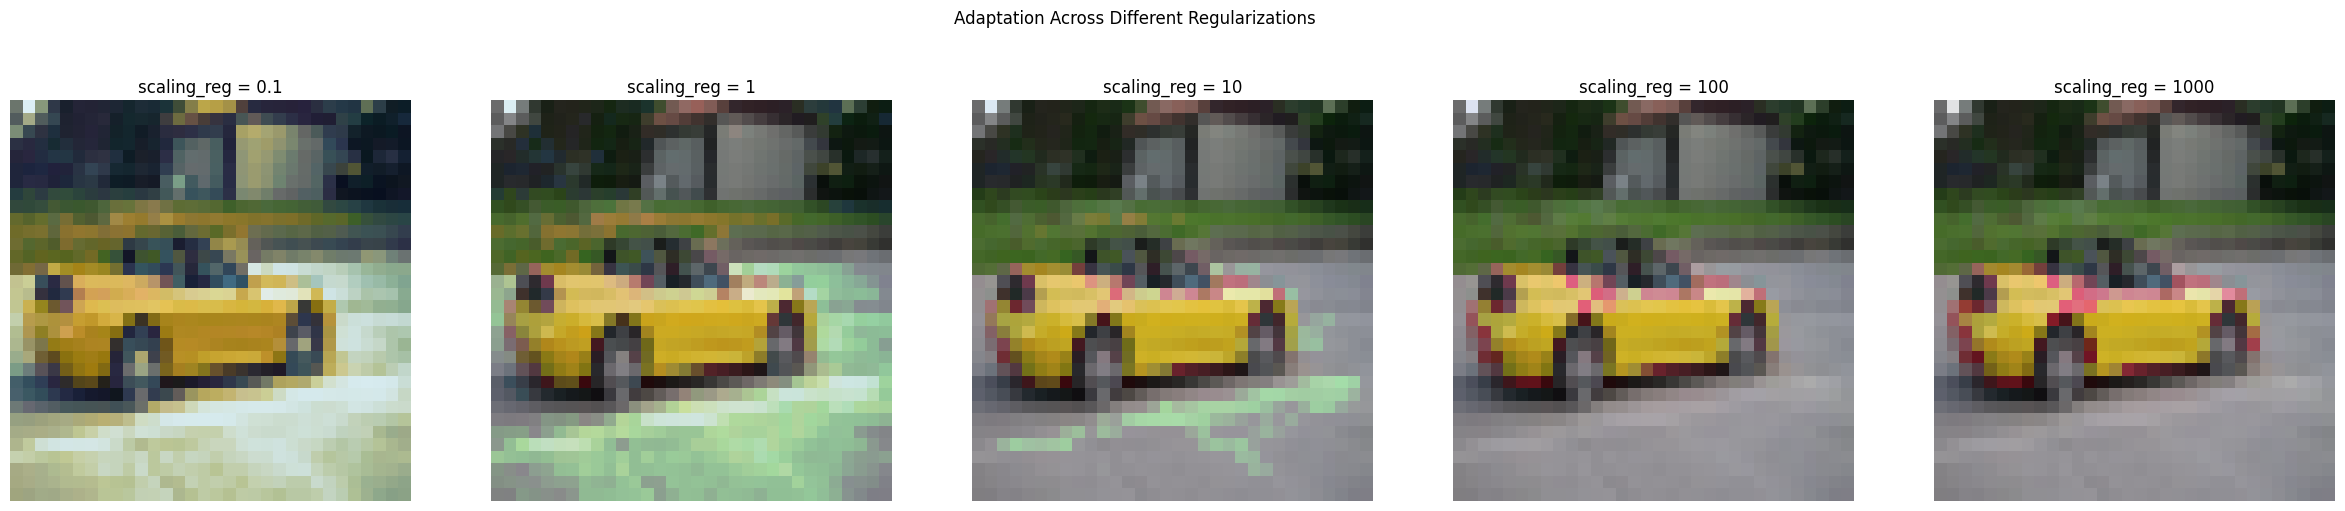

In [ ]:
scaling_reg_list = [0.1, 1, 10, 100, 1000]
plt.figure(figsize=(30, 6))


for idx, scaling_reg in enumerate(scaling_reg_list):
    # Compute the entropic map with current scaling_reg
    map_l1 = entropic_map(X2_train, X1_train, costs.ElasticL1(scaling_reg))  # l1 norm

    # Perform out of sample prediction
    X2_estimated = map_l1(X2) #estimating X2 adapted to the colors of X1

    # Convert matrix to image format and normalize
    I2_adapted = minmax(mat2im(X2_estimated, I1.shape))

    # Plotting the result
    plt.subplot(1, len(scaling_reg_list), idx + 1)
    plt.imshow(I2_adapted)
    plt.axis('off')
    plt.title(f'scaling_reg = {scaling_reg}')

plt.suptitle('Adaptation Across Different Regularizations')
plt.show()

The higher `scaling_reg` is, the more "selective" the model becomes about which pixels change color. When `scaling_reg` is low, the general range of colors changes. When `scaling_reg` is high, only the red pixels change to yellow. This could be a consequence of the sparsity and shrinkage induced by sparsity inducing norms.